# Classificação de Imagens: Cães vs. Gatos com PyTorch

**Objetivos de aprendizagem**  
- Compreender o funcionamento de redes convolucionais aplicadas à visão computacional.  
- Praticar o pré-processamento de imagens para classificação.  
- Avaliar e interpretar o desempenho de modelos CNN em tarefas reais.  

CNN para classificar imagens de _Dogs_ vs. _Cats_.  

In [1]:
# Imports e Transformações

import os                               # Para manipulação de arquivos e diretórios
import torch                            # Biblioteca principal para deep learning
import torch.nn as nn                   # Módulo para redes neurais (camadas, funções)
import torch.nn.functional as F        # Funções para operações nas redes (ativação, perda)
from torch.utils.data import random_split, DataLoader  # Para dividir dados e carregar batches
from torchvision import transforms, datasets           # Transformações e datasets padrão
from torchvision.utils import make_grid                 # Para criar grids de imagens (visualização)
import matplotlib.pyplot as plt           # Biblioteca para plotar gráficos e imagens
from PIL import Image                     # Biblioteca para abrir/manipular imagens

# Definir o device (CPU ou GPU) para treinar e inferir
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando device:", device)          # Mostra qual hardware está sendo usado

# Transformações aplicadas nas imagens de treino para aumentar dados e preparar entrada
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),        # Redimensiona imagem para 224x224 pixels (padrão para muitos modelos)
    transforms.RandomHorizontalFlip(),   # Aplica espelhamento horizontal aleatório (data augmentation)
    transforms.RandomRotation(15),       # Rotaciona aleatoriamente a imagem até ±15 graus (data augmentation)
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Ajusta brilho e contraste para variar imagens
    transforms.ToTensor(),                # Converte imagem PIL para tensor PyTorch (valores 0 a 1)
    transforms.Normalize(mean=[0.485,0.456,0.406],   # Normaliza com média e desvio padrão do ImageNet
                         std =[0.229,0.224,0.225])   # Para melhorar convergência do modelo
])

# Transformações para validação e teste — só prepara, sem alterar imagens para avaliação justa
test_transforms = transforms.Compose([
    transforms.Resize((224,224)),        # Redimensiona para 224x224 pixels (padronização)
    transforms.ToTensor(),                # Converte para tensor PyTorch
    transforms.Normalize(mean=[0.485,0.456,0.406],  # Normaliza com mesmo padrão do treino
                         std =[0.229,0.224,0.225])
])


Usando device: cpu


# Organizar os arquivos na pasta train por Dog e Cat

In [ ]:
import os                # Para manipulação de arquivos e diretórios
import shutil            # Para mover arquivos entre pastas

# Diretório onde estão as imagens originais misturadas
train_dir = "train"

# Define os caminhos das subpastas para gatos e cachorros dentro de train
cat_dir = os.path.join(train_dir, "cat")
dog_dir = os.path.join(train_dir, "dog")

# Cria as subpastas cat e dog se elas não existirem ainda
os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

# Percorre todos os arquivos na pasta train
for filename in os.listdir(train_dir):
    fpath = os.path.join(train_dir, filename)  # caminho completo do arquivo
    # Verifica se é um arquivo (não uma pasta)
    if os.path.isfile(fpath):
        # Se o nome do arquivo começar com "cat" (ignorando maiúsculas/minúsculas)
        if filename.lower().startswith("cat"):
            # Move o arquivo para a pasta cat
            shutil.move(fpath, os.path.join(cat_dir, filename))
        # Se o nome do arquivo começar com "dog"
        elif filename.lower().startswith("dog"):
            # Move o arquivo para a pasta dog
            shutil.move(fpath, os.path.join(dog_dir, filename))

# Mensagem confirmando que a organização foi concluída
print("Imagens organizadas em train/cat e train/dog.")


Imagens organizadas em train/cat e train/dog.


# Carregamento e Split dos Dados (Código)

In [ ]:
# Define os caminhos das pastas de treino e teste
train_dir = "train/"
test_dir  = "test/test/"

# Cria um dataset a partir das imagens organizadas nas subpastas "cat" e "dog" dentro de train_dir
# Aplica as transformações definidas para treino (data augmentation e normalização)
full_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)

# Calcula o número total de imagens no dataset completo
n_total = len(full_dataset)

# Define quantidades para as divisões:
# 70% para treino
n_train = int(0.70 * n_total)
# 15% para validação
n_val = int(0.15 * n_total)
# O restante para um teste interno (15%)
n_test_int = n_total - n_train - n_val

# Divide o dataset completo em três subsets: treino, validação e teste interno
# Usando random_split com uma seed fixa para garantir reproducibilidade
train_ds, val_ds, test_int_ds = random_split(
    full_dataset, [n_train, n_val, n_test_int],
    generator=torch.Generator().manual_seed(42)
)

# Define o tamanho do batch para os DataLoaders
batch_size = 32

# Cria DataLoader para treino:
# shuffle=True para embaralhar os dados a cada época, melhor para treino
# num_workers=4 para usar 4 subprocessos carregando dados em paralelo (acelera carregamento)
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4)

# DataLoader para validação:
# shuffle=False para manter ordem e facilitar avaliação
val_loader = DataLoader(val_ds, batch_size, shuffle=False, num_workers=4)

# DataLoader para teste interno (divisão do treino):
# também sem shuffle para manter ordem
test_int_loader = DataLoader(test_int_ds, batch_size, shuffle=False, num_workers=4)


# Visualização de Exemplos

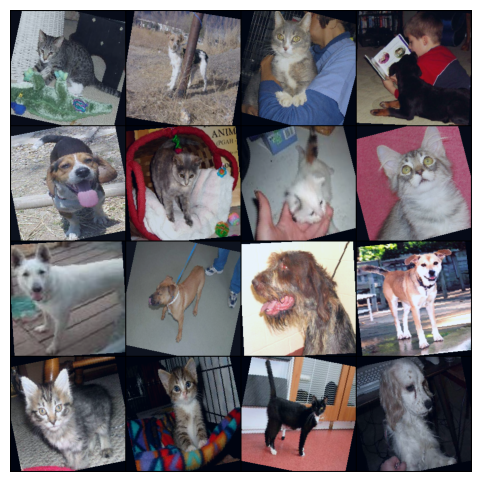

In [ ]:
# Pega o primeiro batch (lote) de imagens e labels do DataLoader de treino
images, labels = next(iter(train_loader))

# Cria uma grade (grid) com as primeiras 16 imagens do batch
# nrow=4 significa que vai ter 4 imagens por linha
# normalize=True faz o ajuste das cores para melhor visualização
grid = make_grid(images[:16], nrow=4, normalize=True)

# Define o tamanho da figura do plot para 6x6 polegadas
plt.figure(figsize=(6,6))

# Mostra a grade de imagens, permutando as dimensões para o formato esperado pelo matplotlib (altura, largura, canais)
plt.imshow(grid.permute(1,2,0))

# Remove os eixos (ticks e números)
plt.axis('off')

# Exibe a imagem
plt.show()


# Definição da CNN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Define uma CNN simples para classificação binária (cachorro ou gato)
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # 1ª camada convolucional: entrada 3 canais (RGB), saída 16 filtros, kernel 3x3, padding 1 para manter tamanho
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # 2ª camada convolucional: entrada 16 canais, saída 32 filtros, kernel 3x3, padding 1
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # 3ª camada convolucional: entrada 32 canais, saída 64 filtros, kernel 3x3, padding 1
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        # Camada de max pooling: reduz a dimensão da imagem pela metade (kernel 2x2, stride 2)
        self.pool  = nn.MaxPool2d(2,2)
        
        # Camada totalmente conectada (densa) que recebe o vetor achatado (flatten) da saída convolucional
        # Como a imagem de entrada é 224x224 e após 3 poolings ela vira 28x28, com 64 canais -> 64*28*28
        self.fc1   = nn.Linear(64*28*28, 512)
        
        # Camada final com um neurônio só, para saída binária (1 saída)
        self.fc2   = nn.Linear(512, 1)
        
    def forward(self, x):
        # Passa pela 1ª convolução + ReLU + pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Passa pela 2ª convolução + ReLU + pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Passa pela 3ª convolução + ReLU + pooling
        x = self.pool(F.relu(self.conv3(x)))
        
        # Achata a saída convolucional para vetor 1D (para as camadas densas)
        x = x.view(x.size(0), -1)
        
        # Passa pela primeira camada densa com ReLU
        x = F.relu(self.fc1(x))
        
        # Passa pela última camada densa e aplica sigmoid para saída entre 0 e 1 (probabilidade)
        x = torch.sigmoid(self.fc2(x))
        
        return x

# Instancia o modelo e envia para device (CPU ou GPU)
model = SimpleCNN().to(device)


# Configuração de Treino

In [ ]:
# Define a função de perda para classificação binária usando Entropia Cruzada Binária
criterion = nn.BCELoss()

# Define o otimizador Adam para atualizar os parâmetros do modelo com taxa de aprendizado 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Define o número de épocas para o treino
num_epochs = 10

# Função auxiliar para calcular a acurácia binária (quantidade de acertos)
def binary_acc(preds, y):
    # Converte as probabilidades em 0 ou 1 (threshold 0.5)
    rounded = (preds > 0.5).float()
    # Compara com os rótulos verdadeiros e conta quantos estão corretos
    correct = (rounded == y).float().sum()
    # Retorna a proporção de acertos no batch
    return correct / y.shape[0]


# Loop de Treinamento e Validação

In [ ]:
# Dicionário para armazenar o histórico de perdas e acurácias durante o treino e validação
history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}

# Loop principal de treinamento, executa num_epochs vezes
for epoch in range(num_epochs):
    # --- Treino ---
    model.train()  # Coloca o modelo em modo treino (ativa dropout, batchnorm, etc)
    running_loss, running_acc = 0.0, 0.0  # Acumuladores para perda e acurácia no epoch
    
    # Itera sobre os batches do loader de treino
    for xb, yb in train_loader:
        # Move dados e rótulos para GPU/CPU conforme device
        xb, yb = xb.to(device), yb.unsqueeze(1).float().to(device)  # yb precisa ser float e shape (batch,1)
        
        optimizer.zero_grad()  # Zera os gradientes acumulados do otimizador
        
        out = model(xb)  # Faz a predição do modelo para o batch
        
        loss = criterion(out, yb)  # Calcula a perda entre predição e rótulo verdadeiro
        
        loss.backward()  # Propaga o gradiente para trás
        
        optimizer.step()  # Atualiza os pesos do modelo
        
        # Acumula perda e acurácia multiplicando pelo tamanho do batch para média ponderada
        running_loss += loss.item() * xb.size(0)
        running_acc  += binary_acc(out, yb) * xb.size(0)
    
    # Calcula média da perda e acurácia para todo o conjunto de treino
    epoch_train_loss = running_loss / n_train
    epoch_train_acc  = running_acc  / n_train
    
    # --- Validação ---
    model.eval()  # Coloca o modelo em modo avaliação (desativa dropout, batchnorm fixo)
    val_loss, val_acc = 0.0, 0.0  # Acumuladores para validação
    
    # Desliga cálculo de gradiente para economizar memória e tempo
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.unsqueeze(1).float().to(device)
            out = model(xb)
            loss = criterion(out, yb)
            val_loss += loss.item() * xb.size(0)
            val_acc  += binary_acc(out, yb) * xb.size(0)
    
    # Calcula média da perda e acurácia no conjunto de validação
    epoch_val_loss = val_loss / n_val
    epoch_val_acc  = val_acc  / n_val
    
    # Salva os valores no histórico para análise posterior ou gráficos
    history["train_loss"].append(epoch_train_loss)
    history["val_loss"].append(epoch_val_loss)
    history["train_acc"].append(epoch_train_acc.item())
    history["val_acc"].append(epoch_val_acc.item())
    
    # Imprime resumo do progresso de treino e validação na época atual
    print(f"Epoch {epoch+1}/{num_epochs}  "
          f"Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f}  "
          f"Val   Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}")


Epoch 1/10  Train Loss: 0.6129, Acc: 0.6595  Val   Loss: 0.5625, Acc: 0.7101
Epoch 2/10  Train Loss: 0.5436, Acc: 0.7241  Val   Loss: 0.5357, Acc: 0.7277
Epoch 3/10  Train Loss: 0.5077, Acc: 0.7485  Val   Loss: 0.5074, Acc: 0.7488
Epoch 4/10  Train Loss: 0.4755, Acc: 0.7727  Val   Loss: 0.4673, Acc: 0.7707
Epoch 5/10  Train Loss: 0.4524, Acc: 0.7879  Val   Loss: 0.4600, Acc: 0.7853
Epoch 6/10  Train Loss: 0.4384, Acc: 0.7976  Val   Loss: 0.4622, Acc: 0.7795
Epoch 7/10  Train Loss: 0.4164, Acc: 0.8082  Val   Loss: 0.4458, Acc: 0.7891
Epoch 8/10  Train Loss: 0.4052, Acc: 0.8151  Val   Loss: 0.4400, Acc: 0.7904
Epoch 9/10  Train Loss: 0.3953, Acc: 0.8211  Val   Loss: 0.4119, Acc: 0.8099
Epoch 10/10  Train Loss: 0.3841, Acc: 0.8244  Val   Loss: 0.3926, Acc: 0.8197


# Plot de Métricas

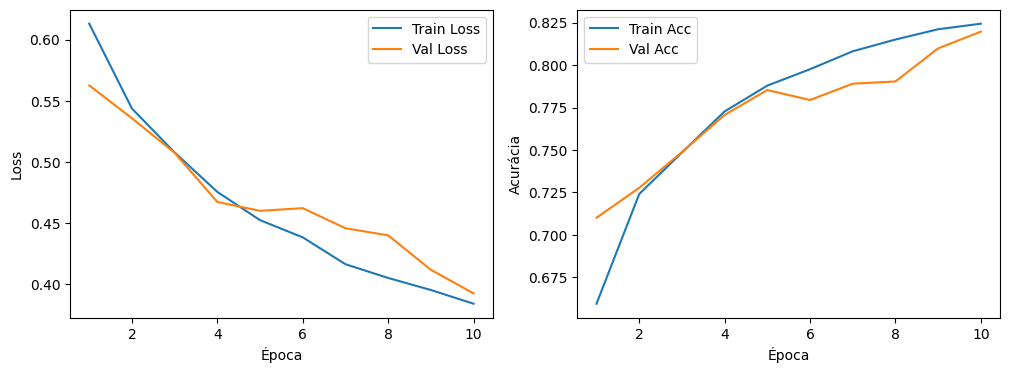

In [ ]:
# Cria uma lista com os números das épocas de 1 até num_epochs (inclusive)
epochs = range(1, num_epochs+1)

# Cria uma figura para os gráficos, com tamanho 12x4 polegadas
plt.figure(figsize=(12,4))

# Primeiro subplot: gráfico da Loss (perda)
plt.subplot(1,2,1)  # 1 linha, 2 colunas, posição 1
plt.plot(epochs, history["train_loss"], label="Train Loss")  # Plota loss do treino
plt.plot(epochs, history["val_loss"],   label="Val Loss")    # Plota loss da validação
plt.xlabel("Época")      # Label eixo X
plt.ylabel("Loss")       # Label eixo Y
plt.legend()             # Adiciona legenda para identificar as linhas

# Segundo subplot: gráfico da Acurácia
plt.subplot(1,2,2)  # 1 linha, 2 colunas, posição 2
plt.plot(epochs, history["train_acc"], label="Train Acc")    # Plota acurácia do treino
plt.plot(epochs, history["val_acc"],   label="Val Acc")      # Plota acurácia da validação
plt.xlabel("Época")      # Label eixo X
plt.ylabel("Acurácia")   # Label eixo Y
plt.legend()             # Adiciona legenda

# Exibe os gráficos na tela
plt.show()


# Avaliação no Conjunto de Teste Interno

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score  # Importa métricas do sklearn

model.eval()  # Coloca o modelo em modo avaliação (desliga dropout, batchnorm etc)
all_preds, all_targets = [], []  # Listas para guardar todas as predições e verdadeiros rótulos

with torch.no_grad():  # Desliga cálculo de gradientes para acelerar inferência e economizar memória
    for xb, yb in test_int_loader:  # Itera sobre o DataLoader do conjunto de teste interno
        xb = xb.to(device)           # Move as imagens para GPU/CPU conforme configurado
        out = model(xb)              # Obtém a saída (logits) do modelo
        preds = (out.cpu().numpy() > 0.5).astype(int).flatten()  # Converte saída para 0 ou 1 com threshold 0.5
        all_preds.extend(preds)      # Adiciona as predições à lista completa
        all_targets.extend(yb.numpy().astype(int))  # Adiciona os rótulos verdadeiros à lista

# Calcula métricas clássicas de classificação binária
precision = precision_score(all_targets, all_preds)  # Precisão: TP / (TP + FP)
recall    = recall_score(all_targets, all_preds)     # Recall: TP / (TP + FN)
f1        = f1_score(all_targets, all_preds)         # F1-score: média harmônica entre precisão e recall

# Imprime as métricas com 3 casas decimais
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1-Score: {f1:.3f}")


NameError: name 'model' is not defined

# Teste em Imagens Externas

In [ ]:
import os
import torch
from torchvision import transforms
from PIL import Image
import pandas as pd

# Define as transformações aplicadas nas imagens do conjunto de teste
# Usamos o mesmo tamanho e normalização do treino para manter consistência
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensiona imagem para 224x224 pixels
    transforms.ToTensor(),           # Converte imagem para tensor PyTorch (C x H x W)
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normaliza pelos valores padrão ImageNet
                         std=[0.229, 0.224, 0.225]),
])

test_folder = "test/test/"  # Caminho da pasta com imagens de teste

# Função para ordenar nomes de arquivos numericamente (1.jpg, 2.jpg, 10.jpg, etc)
def sort_key(fname):
    return int(os.path.splitext(fname)[0])  # extrai o número antes da extensão

# Lista os arquivos da pasta e ordena usando a função acima
test_images = sorted(os.listdir(test_folder), key=sort_key)

model.eval()  # Coloca o modelo em modo avaliação (desliga dropout, batchnorm, etc)

results = []  # Lista para armazenar resultados (id, probabilidade)

with torch.no_grad():  # Desliga cálculo de gradientes para inferência mais rápida e menos uso de memória
    for img_name in test_images:
        img_path = os.path.join(test_folder, img_name)          # Caminho completo da imagem
        img = Image.open(img_path).convert("RGB")               # Abre imagem e converte para RGB
        img_t = test_transform(img).unsqueeze(0).to(device)     # Aplica transformações e adiciona dimensão batch
        
        out = model(img_t)                                       # Passa a imagem pelo modelo (saída bruta)
        prob = torch.sigmoid(out).item()                         # Aplica sigmoide para obter probabilidade de ser cachorro
        
        img_num = os.path.splitext(img_name)[0]  # Remove extensão para ficar só o número da imagem
        results.append((img_num, prob))           # Adiciona o resultado na lista

# Cria DataFrame pandas com colunas "id" e "label" (probabilidade)
df = pd.DataFrame(results, columns=["id", "label"])

# Salva os resultados em arquivo CSV para submissão
df.to_csv("submission.csv", index=False)
